# 1 Import các thư viện cần thiết và cấu hình

**1.1 Các thư viện cần thiết**

In [345]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import random
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import BatchNormalization
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50




**1.2 Cấu hình**

In [346]:
TRAIN_DIR = "D:/Do_an_KPDL/dataset/train"
VAL_DIR = "D:/Do_an_KPDL/dataset/val" 
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 150
NUM_CLASSES = 3

In [347]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

*Giải thích:* Trong bài này, các nhãn lớp được xác định thông qua tên các thư mục con. Khi sử dụng flow_from_directory, Keras tự động ánh xạ mỗi thư mục con thành một nhãn số, giúp đơn giản hóa quá trình tiền xử lý dữ liệu.

# 2 Khám phá dữ liệu (EDA)

**2.1 Kiểm tra số lượng ảnh của mỗi lớp**

In [348]:
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts
#In số lượng ảnh ở mỗi lớp
train_counts = count_images(TRAIN_DIR)
val_counts = count_images(VAL_DIR)
print("Train set:", train_counts)
print("Validation set:", val_counts)

Train set: {'angular_leaf_spot': 345, 'bean_rust': 348, 'healthy': 342}
Validation set: {'angular_leaf_spot': 44, 'bean_rust': 45, 'healthy': 44}


**2.2 Trực quan hóa số lượng ảnh ở mỗi lớp:**

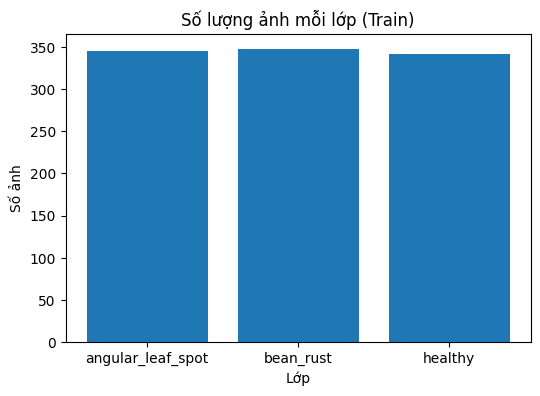

In [349]:
plt.figure(figsize=(6,4))
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Số lượng ảnh mỗi lớp (Train)")
plt.ylabel("Số ảnh")
plt.xlabel("Lớp")
plt.show()

*Nhận xét:* Do lần lượt ở các lớp 'angular_leaf_spot': 345, 'bean_rust': 348, 'healthy': 342 nên thấy rằng vì số lượng các ảnh ở các cột không chênh lệch quá nhiều nên nhìn có vẻ như dữ liệu đã được cân bằng

**2.3 Hiển thị một vài ảnh mẫu của mỗi lớp**

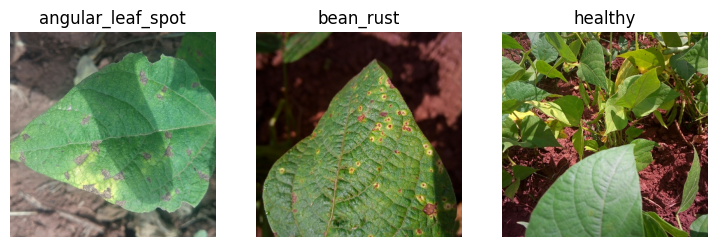

In [350]:
plt.figure(figsize=(9,3))
for i, class_name in enumerate(os.listdir(TRAIN_DIR)):
    class_path = os.path.join(TRAIN_DIR, class_name)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)    
    img = load_img(img_path)
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
plt.show()

*Chú thích:* Ở trên hiển thị ngẫu nhiên 3 ảnh ở các lớp khác nhau

**2.4 Kiểm tra kích thước của ảnh**

In [351]:
sizes = []
for class_name in os.listdir(TRAIN_DIR):
    class_path = os.path.join(TRAIN_DIR, class_name)
    img_name = os.listdir(class_path)[0]
    img_path = os.path.join(class_path, img_name)
    with Image.open(img_path) as img:
        sizes.append(img.size)
sizes

[(500, 500), (500, 500), (500, 500)]

*Chú thích:* Kết quả cho ra kích thước gốc ở các ảnh 

*Nhận xét sau khi khám phá dữ liệu (EDA):* Dataset gồm 3 lớp: angular_leaf_spot, bean_rust và healthy. Số lượng ảnh giữa các lớp có sự chênh lệch nhẹ, do đó kỹ thuật Data Augmentation được sử dụng ở các bước tiếp theo nhằm giảm nguy cơ overfitting. Các ảnh có kích thước không đồng nhất và cần được chuẩn hóa về cùng kích thước trước khi đưa vào mô hình CNN.

# 3 Tiền xử lý dữ liệu và Data Augmentation

**3.1 Chuẩn hóa dữ liệu ảnh**

In [318]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)
val_datagen = ImageDataGenerator(
    rescale=1./255
)

*Mục đích:* Chuyển pixel từ [0–255] -> [0–1]

**3.2 Data Augmentation cho tập train**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    # BRIGHTNESS: Nhẹ để giữ màu sắc đặc trưng
    # - Xanh tươi (Healthy)
    # - Nâu + viền vàng (Angular Leaf Spot)
    # - Nâu đỏ gỉ sắt (Bean Rust)
    brightness_range=[0.85, 1.15],
    # FILL: Reflect để giữ texture tự nhiên của lá
    fill_mode='reflect'
)

# Validation - Chỉ rescale (không augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255
)

*Mục đích:* Tránh overfitting và mô phỏng điều kiện chụp khác nhau (ánh sáng, góc lá)

**3.3 Resize ảnh về kích thước chuẩn**

In [320]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


*Mục đích:* giúp đánh giá ổn hơn

**3.4 Kiểm tra dữ liệu sau tiền xử lý**

In [321]:
images, labels = next(train_generator)
print(images.shape)   
print(images.min(), images.max())  

(32, 224, 224, 3)
0.0 1.0


*Giải thích:* Sau tiền xử lý, mỗi batch dữ liệu gồm 32 ảnh kích thước 224×224×3. Giá trị pixel được chuẩn hóa về khoảng [0,1], đảm bảo dữ liệu đầu vào phù hợp cho huấn luyện mạng CNN

**3.5 Trực quan ảnh sau Data Augmentation**

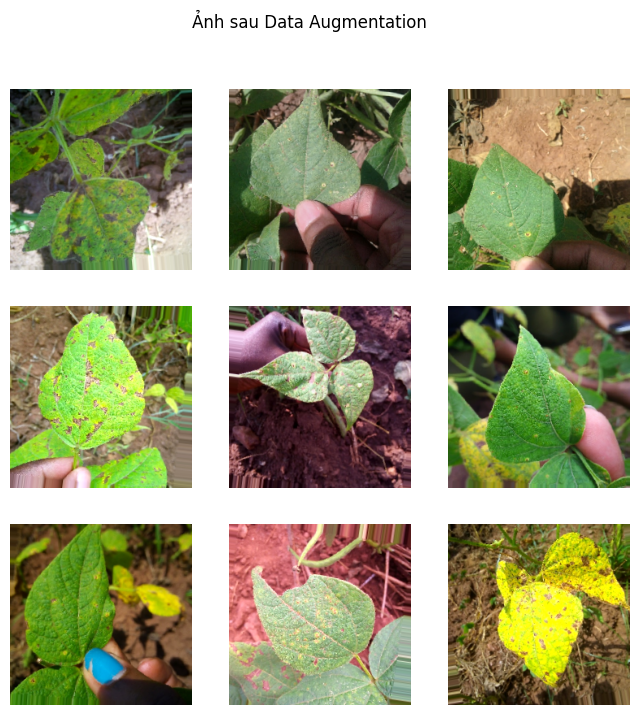

In [322]:
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.axis("off")
plt.suptitle("Ảnh sau Data Augmentation")
plt.show()

*Giải thích:* Các ảnh được resize về kích thước 224×224 và chuẩn hóa về khoảng [0,1]

# 4 CNN

**4.1 Xây dựng mô hình CNN**

In [323]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'), 
    BatchNormalization(),  
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

*Giải thích:*

* Conv2D: Trích xuất đặc trưng (đường viền, đốm bệnh). Cụ thể hơn là chọn các số filters là 32, 64, 128 là vì layer: Conv1 với số filters 32 sẽ học cạnh, màu, đốm nhỏ. Layer: Conv2 với số filter 64 sẽ học vết bệnh, mảng màu. Layer: Conv3 với số filter 128 sẽ học được hình dạng tổn thương phức tạp.(Lưu ý: không cần phải chọn 256 - 512 vì dễ gây ra tình trạng overfitting)

* Chọn kernel size = (3,3) là đó là chuẩn, tốt ưu nhất.

* ReLU: Phi tuyến, giúp học đặc trưng phức tạp

* MaxPooling: Giảm kích thước, chống overfitting. Cụ thể hơn là việc mỗi Conv đều có MaxPooling(2,2) là để giảm kích thước mỗi chiều đi 1 nửa và tăng tính bất biến với dịch chuyển nhỏ.

* Flatten: Chuyển feature map về vector

* Dense: Phân loại. Cụ thể hơn là cho Dense = 128 neurons, điều này giúp kết hợp với đặc trưng và không quá lớn để gây ra tình trạng overfitting

* Softmax: Để xác suất 3 lớp

* Dropout: Để giảm overfitting. Cụ thể hơn là cho Dropout = 0.5 để tắt ngẫu nhiên 50% neuron và buộc mạng học đặc trưng ổn định hơn.

**Phần Callback cho mô hình**

In [324]:
cb = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,        
        patience=10,       
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=25,       
        min_delta=1e-3,
        restore_best_weights=True,
        verbose=1
    )
]

**4.2 Compile mô hình**

In [325]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

*Chú thích:* việc chọn adam: do khả năng hội tụ nhanh và ổn định trên các mô hình CNN với tập dữ liệu vừa phải. Chọn categorical_crossentropy vì phù hợp với bài toán multi-class. Chọn accuracy làm metric để sử dụng làm chỉ số đánh giá.

Optimizer Adam được sử dụng với learning rate được thiết lập rõ ràng nhằm kiểm soát tốc độ cập nhật trọng số trong quá trình huấn luyện

**4.3 Kiểm tra mô hình**

In [326]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_68 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,515 (1.74 MB)

 Trainable params: 455,747 (1.74 MB)

 Non-trainable params: 768 (3.00 KB)

**Nhận xét:** CNN được huấn luyện trên dữ liệu đã được tăng cường (Data Augmentation) nhằm cải thiện khả năng tổng quát hóa và giảm overfitting.

# 5 Huấn luyện Model

**5.1 Huấn luyện mô hình**

In [327]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=cb    
)

Epoch 1/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 955ms/step - accuracy: 0.5948 - loss: 0.9809 - val_accuracy: 0.3308 - val_loss: 1.0929 - learning_rate: 1.0000e-04
Epoch 2/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 969ms/step - accuracy: 0.6547 - loss: 0.8381 - val_accuracy: 0.3308 - val_loss: 1.0944 - learning_rate: 1.0000e-04
Epoch 3/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 933ms/step - accuracy: 0.6789 - loss: 0.7707 - val_accuracy: 0.3308 - val_loss: 1.0931 - learning_rate: 1.0000e-04
Epoch 4/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 925ms/step - accuracy: 0.7089 - loss: 0.7308 - val_accuracy: 0.3308 - val_loss: 1.0873 - learning_rate: 1.0000e-04
Epoch 5/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 920ms/step - accuracy: 0.7166 - loss: 0.7371 - val_accuracy: 0.3308 - val_loss: 1.0936 - learning_rate: 1.0000e-04
Epoch 6/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 929ms/step - accuracy: 0.7282 - loss: 0.7025 - val_accuracy: 0.4060 - val_loss: 1.0762 - learning_rate: 1.0000e-04
Epoch 7/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 959ms/ste

Epoch có val_accuracy cao nhất

In [328]:
best_epoch_acc = max(range(len(history.history['val_accuracy'])),
                     key=lambda i: history.history['val_accuracy'][i])

print("Best Epoch (by val_accuracy):", best_epoch_acc + 1)
print("Best Val Accuracy:", history.history['val_accuracy'][best_epoch_acc])

Best Epoch (by val_accuracy): 65
Best Val Accuracy: 0.9398496150970459


Epoch có val_loss thấp nhất

In [329]:
best_epoch_loss = min(range(len(history.history['val_loss'])),
                      key=lambda i: history.history['val_loss'][i])

print("Best Epoch (by val_loss):", best_epoch_loss + 1)
print("Best Val Loss:", history.history['val_loss'][best_epoch_loss])

Best Epoch (by val_loss): 101
Best Val Loss: 0.32502517104148865


# 6 Đánh giá model và Visualization

**6.1 Theo dõi quá trình huấn luyện**

In [330]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

*Giải thích:*

* train_generator: dữ liệu đã resize + normalize + augmentation

* validation_data: dữ liệu chỉ resize + normalize

* epochs: số lần mô hình học qua toàn bộ tập train

**6.2 Trực quan quá trình học trong quá trình huấn luyện**

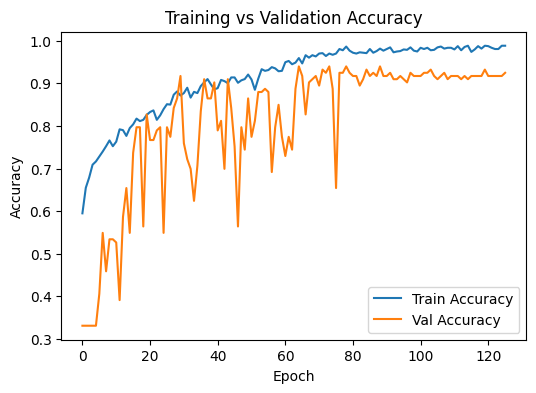

In [331]:
#Biểu đồ Accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

*Nhận xét:* Trong quá trình huấn luyện, độ chính xác trên tập huấn luyện và tập validation đều tăng dần, trong khi hàm mất mát giảm, cho thấy mô hình học ổn định. Sự chênh lệch giữa train và validation không lớn, chứng tỏ các kỹ thuật Data Augmentation và Dropout giúp hạn chế overfitting

**6.3 Đánh giá tổng thể**

In [332]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.9173 - loss: 0.3250
Validation Loss: 0.32502517104148865
Validation Accuracy: 0.9172932505607605


**6.4 Dự đoán trên tệp validation**

In [333]:
y_pred_prob = model.predict(val_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = val_generator.classes

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


*Mục đích:* Chuyển kết quả dự đoán của mô hình thành nhãn cụ thể và so sánh với nhãn thật để đánh giá mô hình

*Giải thích:* 

* Dòng đầu tiên sẽ làm duyệt qua toàn bộ tập validation và Với mỗi ảnh sẽ xuất ra xác suất 3 lớp (VD: [0.05, 0.10, 0.85])

* Dòng thứ hai sẽ chuyển xác suất về nhãn dự đoán (VD:[0.05, 0.10, 0.85] -> 2 )

* Dòng thứ ba là nhãn thật và Keras tự gán theo thứ tự thư mục ( VD: angular_leaf_spot -> 0, bean_rust -> 1 và healthy -> 2)

**6.5 Áp dụng Confusion Matrix**

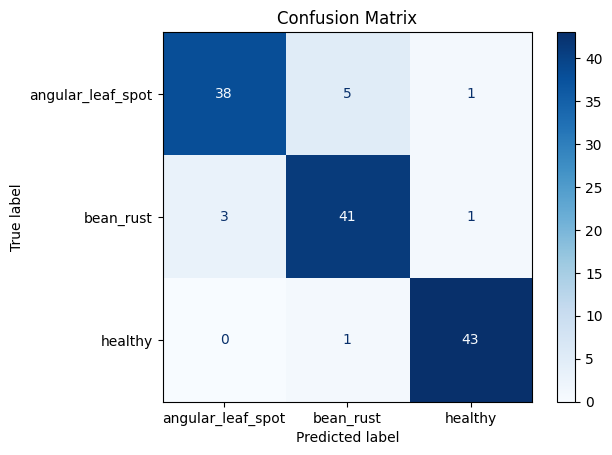

In [334]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=val_generator.class_indices.keys()
)

disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

*Chú thích:* Mô hình phân loại tốt lớp healthy, trong khi còn nhầm lẫn nhẹ giữa angular_leaf_spot và bean_rust do đặc trưng hình ảnh tương đối giống nhau.

**6.6 Classification Report**

In [335]:
print(classification_report(
    y_true,
    y_pred,
    target_names=val_generator.class_indices.keys()
))

                   precision    recall  f1-score   support

angular_leaf_spot       0.93      0.86      0.89        44
        bean_rust       0.87      0.91      0.89        45
          healthy       0.96      0.98      0.97        44

         accuracy                           0.92       133
        macro avg       0.92      0.92      0.92       133
     weighted avg       0.92      0.92      0.92       133



**6.7 Trực quan dự đoán đúng & sai**

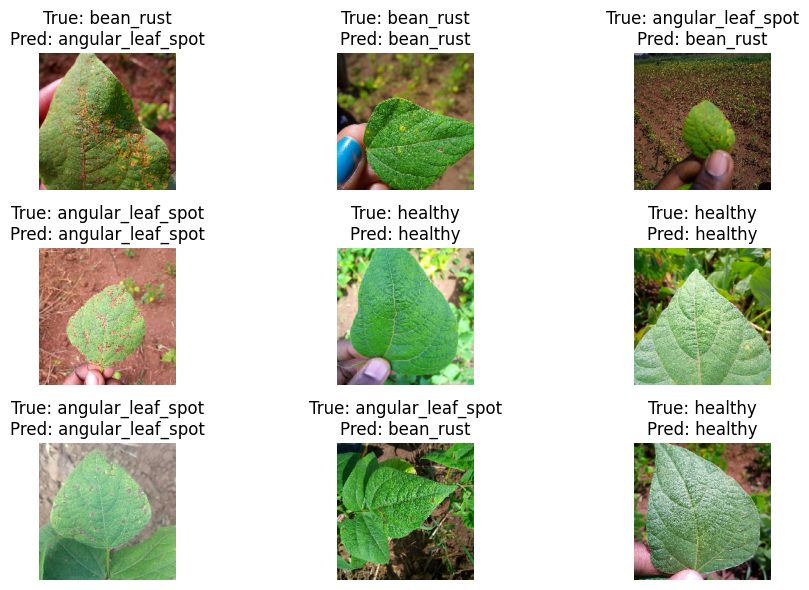

In [336]:
class_names = list(val_generator.class_indices.keys())
plt.figure(figsize=(10,6))
for i in range(9):
    idx = random.randint(0, len(y_true)-1)
    img_path = val_generator.filepaths[idx]
    img = load_img(img_path, target_size=IMG_SIZE)
    
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

*Nhận xét sau phần 6.7:* 

1.Về nhận xét tích cực:

Lớp healthy

Hầu hết ảnh healthy -> predicted healthy

lá có đặc điểm:

* màu xanh đồng đều

* ít hoặc không có đốm

* gân lá rõ

->Mô hình học rất tốt đặc trưng của lá khỏe ( điều được thể hiện ở confusion matrix)

Một số ảnh bệnh rõ ràng:

Ảnh angular_leaf_spot có:

* đốm vàng/nâu đỏ

* phân bố đặc trưng

Model dự đoán đúng

-> Cho thấy CNN đã học được pattern bệnh rõ nét, không phải đoán ngẫu nhiên.

2.Về nhận xét tiêu cực:

Nguyên nhân 1: Đặc trưng thị giác tương tự

Bệnh giai đoạn đầu:

* đốm nhỏ

* ít tương quan

CNN khó phân biệt với nhiễu tự nhiên trên lá

Nguyên nhân 2: Độ phân giải sau resize

* Ảnh gốc: 500×500

* Sau resize: 224×224

* Một số chi tiết nhỏ bị mất

Nguyên nhân 3: CNN còn đơn giản

*Nhận xét chung:* Qua trực quan các kết quả dự đoán, mô hình phân loại tốt các ảnh lá khỏe và các trường hợp bệnh có biểu hiện rõ ràng. Tuy nhiên, mô hình còn nhầm lẫn một số ảnh bệnh ở giai đoạn sớm với lớp healthy, do đặc trưng thị giác chưa đủ rõ ràng và kích thước ảnh bị giảm trong quá trình tiền xử lý. Điều này cho thấy mô hình còn hạn chế trong việc nhận diện các tổn thương nhỏ và tinh vi.

# 7 Mở rộng thêm 

**Mô hình Resnet50**

Train generator:

In [352]:

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    # BRIGHTNESS: Nhẹ để giữ màu sắc đặc trưng
    # - Xanh tươi (Healthy)
    # - Nâu + viền vàng (Angular Leaf Spot)
    # - Nâu đỏ gỉ sắt (Bean Rust)
    brightness_range=[0.85, 1.15],
    # FILL: Reflect để giữ texture tự nhiên của lá
    fill_mode='reflect'
)

Validation generator

In [353]:
# Validation - Chỉ rescale (không augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [354]:
train_gen_resnet = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,        # (224,224)
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen_resnet = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


In [355]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False  

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model_resnet = Model(inputs=base_model.input, outputs=output)

*Ghi chú:* Đầu ra từ ResNet pretrained được đưa qua Global Average Pooling và các lớp Dense nhằm trích xuất và phân loại đặc trưng, trong đó Dropout được sử dụng để giảm overfitting.

In [357]:
model_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

In [ ]:
history_resnet = model_resnet.fit(
    train_gen_resnet,
    epochs=50,                   
    validation_data=val_gen_resnet,
    #callbacks=cb
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.5348 - loss: 1.0526 - val_accuracy: 0.8045 - val_loss: 0.5967
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.7727 - loss: 0.6290 - val_accuracy: 0.8797 - val_loss: 0.4803
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8095 - loss: 0.5633 - val_accuracy: 0.8797 - val_loss: 0.4119
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8511 - loss: 0.5011 - val_accuracy: 0.8797 - val_loss: 0.3854
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8656 - loss: 0.4668 - val_accuracy: 0.9173 - val_loss: 0.3559
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8888 - loss: 0.4323 - val_accuracy: 0.9248 - val_loss: 0.3401
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8714 - loss: 0.4322 - val_accuracy: 0.9098 - val_loss: 0.3335
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8723 - loss: 0.4414 - val_accuracy: 0.9173 - val_loss:

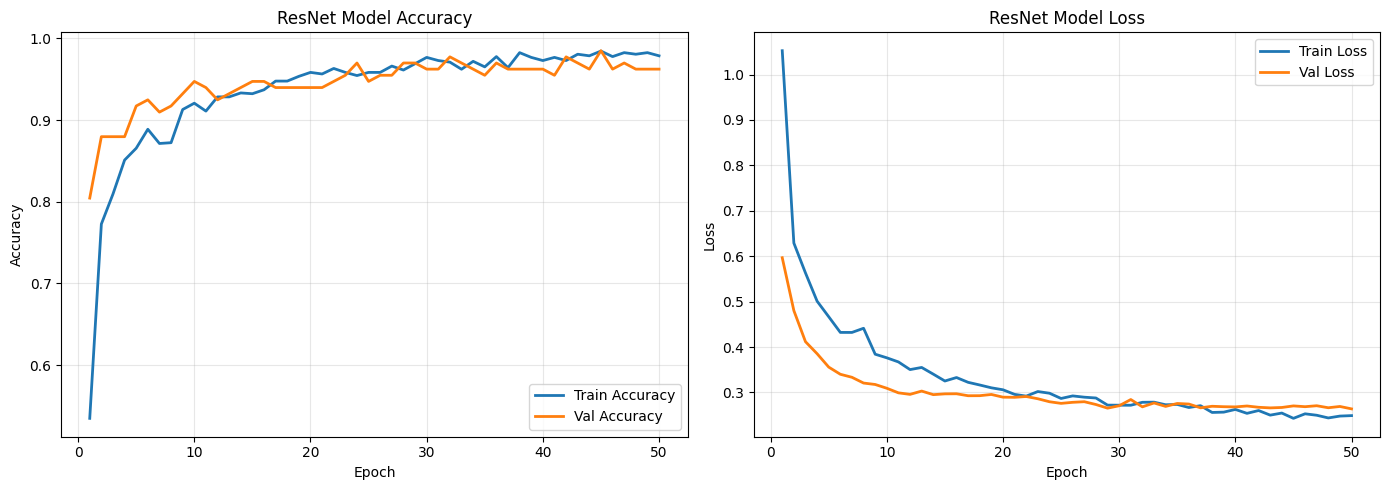

In [ ]:
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Train Accuracy', linewidth=2)
plt.plot(epochs, val_acc, label='Val Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet Model Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Train Loss', linewidth=2)
plt.plot(epochs, val_loss, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet Model Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


*Nhận xét:*

Về biểu đồ accuracy ( bên trái )

- Giai đoạn đầu (epoch 1–5):Độ chính xác trên tập huấn luyện và tập validation tăng rất nhanh. Điều này cho thấy ResNet pretrained trích xuất đặc trưng hiệu quả ngay từ đầu.

- Giai đoạn giữa (epoch 5–20):Đường train accuracy và validation accuracy tăng ổn định và bám sát nhau. Khoảng cách nhỏ giữa hai đường cho thấy mô hình học tốt và chưa có dấu hiệu overfitting.

- Giai đoạn sau (epoch 20–50):Cả hai đường accuracy đạt trạng thái bão hòa ở mức cao (~96–98%) và dao động nhẹ quanh giá trị này. Validation accuracy ổn định, chứng tỏ mô hình có khả năng tổng quát hóa tốt trên dữ liệu chưa thấy.

Từ đây rút ra được tình trạng của mô hình là: Không xuất hiện hiện tượng train tăng mạnh nhưng val giảm, nên có thể kết luận mô hình không bị overfitting đáng kể.

Về biểu đồ Loss ( bên phải )

- Epoch đầu: Train loss và validation loss giảm nhanh, phản ánh quá trình học hiệu quả và tốc độ hội tụ nhanh của ResNet.

- Epoch 10–25: Loss tiếp tục giảm nhưng với tốc độ chậm hơn, cho thấy mô hình dần tiệm cận cực tiểu của hàm mất mát.

- Epoch sau 25:Train loss và validation loss duy trì ở mức thấp (~0.25–0.30) và ổn định, không xuất hiện hiện tượng validation loss tăng ngược lại.

Tình trạng của mô hình: hội tụ tốt và ổn định, không có dấu hiệu học quá mức.

In [365]:
# Dự đoán
y_pred_prob = model_resnet.predict(val_gen_resnet)
y_pred = np.argmax(y_pred_prob, axis=1)

# Nhãn thật
y_true = val_gen_resnet.classes

class_names = list(val_gen_resnet.class_indices.keys())
print(class_names)

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
['angular_leaf_spot', 'bean_rust', 'healthy']


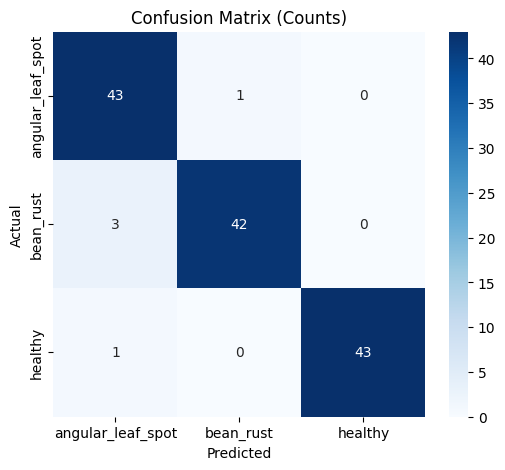

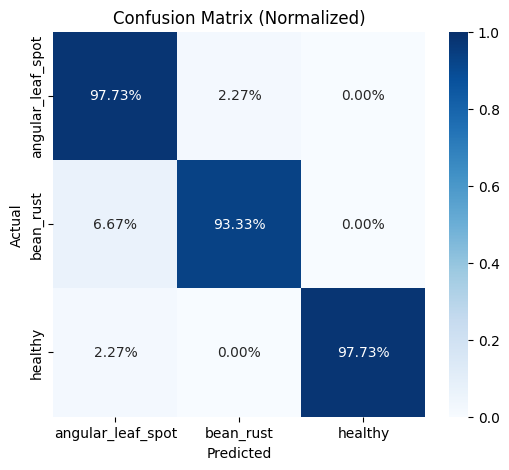

In [366]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Counts)')
plt.show()

cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    vmin=0,
    vmax=1
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()


*Nhận xét:*

1.Phân tích Confusion Matrix 

| Lớp thực \ Dự đoán | angular_leaf_spot | bean_rust | healthy |
|--------------------|------------------:|----------:|--------:|
| angular_leaf_spot  | 43               | 1         | 0       |
| bean_rust          | 3                | 42        | 0       |
| healthy            | 1                | 0         | 43      |

Chi tiết:

1.1 angular_leaf_spot

* Tổng số mẫu: 44

* Dự đoán đúng: 43

* Dự đoán sai: 1 mẫu bị nhầm sang bean_rust

* Không có mẫu nào bị nhầm sang healthy

Vậy mô hình nhận diện rất tốt lớp này, lỗi nhầm rất nhỏ và chỉ xảy ra với lớp bệnh có đặc trưng tương đồng.

1.2 bean_rust

* Tổng số mẫu: 45

* Dự đoán đúng: 42

* Dự đoán sai: 3 mẫu bị nhầm sang angular_leaf_spot

* Không có mẫu nào bị nhầm sang healthy

Vậy đây là lớp có số lỗi nhiều nhất, tuy nhiên lỗi chỉ xảy ra giữa hai lớp bệnh, không nhầm với lá khỏe.

1.3 healthy

* Tổng số mẫu: 44

* Dự đoán đúng: 43

* Dự đoán sai: 1 mẫu bị nhầm sang angular_leaf_spot

* Không có mẫu nào bị nhầm sang bean_rust

Vậy mô hình nhận diện lá khỏe rất chính xác, gần như không bị nhầm lẫn.

2.Phân tích Confusion Matrix (Normalized)

| Lớp thực \ Dự đoán | angular_leaf_spot | bean_rust | healthy |
|--------------------|-----------------:|----------:|--------:|
| angular_leaf_spot  | 97.73%     | 2.27%     | 0.00%   |
| bean_rust          | 6.67%            | 93.33%| 0.00%   |
| healthy            | 2.27%            | 0.00%     | 97.73% |

Chi tiết:

2.1 angular_leaf_spot

* 97.73% mẫu được phân loại đúng

* 2.27% bị nhầm sang bean_rust

* 0% bị nhầm sang healthy

Vậy Độ chính xác rất cao, mô hình phân biệt rõ bệnh và lá khỏe.

2.2 bean_rust

* 93.33% mẫu được phân loại đúng

* 6.67% bị nhầm sang angular_leaf_spot

* 0% bị nhầm sang healthy

Vậy do đặc trưng hình thái của bean_rust và angular_leaf_spot có sự tương đồng về màu sắc và vùng tổn thương nên kết quả chưa được tốt.

2.3 healthy

* 97.73% mẫu được phân loại đúng

* 2.27% bị nhầm sang angular_leaf_spot

* 0% bị nhầm sang bean_rust

Vậy mô hình gần như không nhầm lá khỏe với bệnh, đây là điểm mạnh rất quan trọng trong ứng dụng thực tế.